# Analysis of monthly return data

## Description

- Calculate mean return per Style

In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

## Load Data

In [2]:
path = '../data/processed/EDY/returns_s_s.feather'
returns = feather.read_dataframe(path)
returns.shape

(348399, 3)

In [3]:
path = '../data/processed/EDY/holdings_summary_s_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(50448, 8)

In [4]:
path = '../data/processed/EDY/holdings_s_s.npz'
holdings = sparse.load_npz(path)
holdings.shape

(50448, 2382968)

In [5]:
path = '../data/raw/portno_map.feather'
portno_map = feather.read_dataframe(path)

## Merge Crsp_Obj_Cd onto returns data

### Merge does not take dates into account -> TODO

In [6]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged.shape

(1976094, 11)

In [7]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(1712476, 11)

In [8]:
returns_merged.sample()

,crsp_fundno,caldt,mret,port_no,fund_no,report_dt,index_fund_flag,et_flag,crsp_obj_cd,mutual_fund,sample
79865,5627.0,2016-03-31,0.06686,1026301.0,5627.0,2017-12-31,MF,MF,EDYG,Y,Y


#### Take only needed columns and reorder them

In [9]:
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','crsp_obj_cd']]

In [10]:
returns_merged.sample()

,caldt,fund_no,port_no,mret,crsp_obj_cd
1129943,2015-09-30,39390.0,1025773.0,-0.006441,EDYB


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [11]:
obj_codes = returns_merged[['crsp_obj_cd']].drop_duplicates()
obj_codes = obj_codes['crsp_obj_cd'].values

In [12]:
returns_merged.sample(10)

,caldt,fund_no,port_no,mret,crsp_obj_cd
1790025,2017-06-30,57275.0,1032633.0,0.007036,EDYB
599233,2017-12-29,23872.0,1024548.0,0.013437,EDYI
467952,2017-05-31,17726.0,1024722.0,0.012433,EDYB
1738674,2016-09-30,56140.0,1032359.0,-0.006289,EDYI
476432,2017-03-31,17954.0,1027276.0,0.004898,EDYG
1058699,2016-07-29,38775.0,1024669.0,0.068078,EDYG
331920,2017-06-30,13177.0,1024298.0,0.013289,EDYB
1017756,2015-06-30,38504.0,1023900.0,-0.018024,EDYG
1619790,2016-06-30,52814.0,1031286.0,0.010518,EDYB
203218,2015-10-30,10240.0,1023177.0,0.081614,EDYG


In [13]:
# Analysis of selected funds
returns_obj = returns_merged.groupby(['crsp_obj_cd','caldt'])['mret'].agg(['mean','count'])

In [14]:
test = returns_obj.loc['EDYB',['mean']]

In [15]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [16]:
returns_obj['cummean'] = returns_obj.groupby('crsp_obj_cd')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [17]:
returns_obj_n = returns_obj.pivot_table(
        values='cummean', 
        index=['caldt'], 
        columns='crsp_obj_cd')

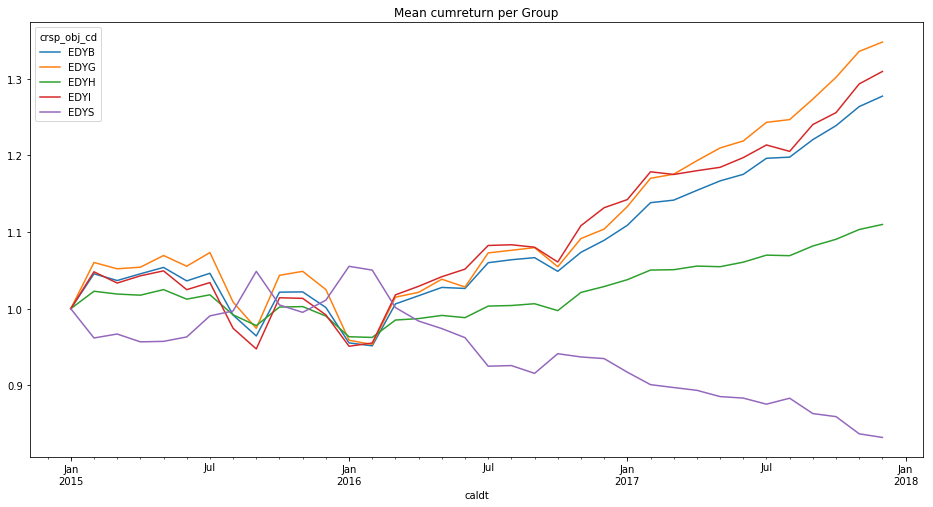

In [18]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')